# Installation


In [24]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 875.9 kB/s eta 0:00:00a 0:00:01


In [1]:
!pip install yfinance

# Importing Packages

In [25]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime, timedelta

# Getting Stock Data

In [3]:
stock_tickers = ['TSLA', 'NFLX', 'NVDA', 'AMD', 'MSFT']
tbill_ticker = '^TNX'
market_ticker = '^GSPC'
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
portfolio = yf.download(stock_tickers, start=start_date, end=end_date)['Close']
Tbill = yf.download(tbill_ticker, start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'tbill'})
market = yf.download(market_ticker, start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'gspc'})

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Risk Free Interest Rates

In [4]:
portfolio.index = portfolio.index.tz_localize(None)
Tbill.index = Tbill.index.tz_localize(None)
market.index = market.index.tz_localize(None)
portfolio.columns = portfolio.columns.str.lower()
if not portfolio.empty and not Tbill.empty and not market.empty:
    returns = portfolio.pct_change()
    tbill_rate = Tbill.pct_change()
    market_returns = market.pct_change()
    returns, tbill_rate = returns.align(tbill_rate, join='inner', axis=0)
    market_returns, tbill_rate = market_returns.align(tbill_rate, join='inner', axis=0)
    returns['tsla'] -= tbill_rate["tbill"]
    returns['nflx'] -= tbill_rate["tbill"]
    returns['nvda'] -= tbill_rate["tbill"]
    returns['amd'] -= tbill_rate["tbill"]
    returns['msft'] -= tbill_rate["tbill"]
    excess_market_return = pd.DataFrame()
    excess_market_return['gspc'] = market_returns['gspc'] - tbill_rate["tbill"]
    returns.dropna(inplace=True)
    excess_market_return.dropna(inplace=True)
    print("Excess Returns:\n", returns.head())
    print("Excess Market Return:\n", excess_market_return.head())
else:
    print("One or more DataFrames are empty. Please check data retrieval.")

Excess Returns:
 Ticker           amd      msft      nflx      nvda      tsla
Date                                                        
2023-10-11  0.006468  0.025161 -0.006906  0.034899  0.010500
2023-10-12 -0.021031 -0.029253 -0.038388 -0.022493 -0.041128
2023-10-13 -0.016396  0.007257  0.002332 -0.013997 -0.012323
2023-10-16 -0.004894 -0.002949 -0.003479 -0.003984 -0.006780
2023-10-17 -0.041049 -0.030394 -0.042785 -0.075445 -0.024988
Excess Market Return:
                 gspc
Date                
2023-10-11  0.017182
2023-10-12 -0.031709
2023-10-13  0.012596
2023-10-16 -0.007336
2023-10-17 -0.028749


# Price of Risk

\begin{align}
  A = \frac{E(r_m) - r_f}{σ_m^2}
\end{align}

In [7]:
average_excess_returns = excess_market_return.mean()
variance = market_returns.var()
a = average_excess_returns / variance
A = a.iloc[0]
A

25.239589508313102

 # Variance Covariance Matrix

In [8]:
S = returns.cov()
S

Ticker,amd,msft,nflx,nvda,tsla
Ticker,,,,,
amd,0.001138,0.000370,0.000439,0.000794,0.000594
msft,0.000370,0.000374,0.000324,0.000395,0.000395
nflx,0.000439,0.000324,0.000623,0.000473,0.000340
nvda,0.000794,0.000395,0.000473,0.001273,0.000573
tsla,0.000594,0.000395,0.000340,0.000573,0.001529


# Market Weights

In [9]:
tsla = yf.Ticker('TSLA')
nflx = yf.Ticker('NFLX')
nvda = yf.Ticker('NVDA')
amd = yf.Ticker('AMD')
msft = yf.Ticker('MSFT')
market_cap = {
    'tsla': tsla.info.get('marketCap', 0),
    'nflx': nflx.info.get('marketCap', 0),
    'nvda': nvda.info.get('marketCap', 0),
    'amd': amd.info.get('marketCap', 0),
    'msft': msft.info.get('marketCap', 0)
}
sum_weights = sum(market_cap.values())
w = np.empty(5)
w[0] = market_cap['tsla'] / sum_weights
w[1] = market_cap['nflx'] / sum_weights
w[2] = market_cap['nvda'] / sum_weights
w[3] = market_cap['amd'] / sum_weights
w[4] = market_cap['msft'] / sum_weights
print("Weights based on market cap: ", w)

Weights based on market cap:  [0.10157776 0.04031559 0.42032167 0.0362829  0.40150209]


# Implied Equilibrium Excess Return

\begin{align}
  π = ASw
\end{align}

In [10]:
pi = A * np.dot(S, w)
pi

array([0.01468829, 0.00913092, 0.01194628, 0.01442907, 0.02154787])

# Views and Link Matrix (Order: tsla, nflx, nvda, amd, msft)

In [11]:
Q = np.array([0.005, 0.01, 0.005])
P = np.array([[0, 0, 0, -1, 1], [0, -1, 1, 0, 0], [-1, 1, 0, 0, 0]])

# Uncertainty About Views

\begin{align}
  \Omega = τPSP^T  
\end{align}

where $\tau = 1$

In [12]:
omega = 1 * np.dot(np.dot(P, S), np.transpose(P))
omega

array([[ 0.00165512, -0.00013231,  0.00019957],
       [-0.00013231,  0.0003483 , -0.00011832],
       [ 0.00019957, -0.00011832,  0.0007721 ]])

# Solving first term of Black Litterman Formula

\begin{align}
  [(τS)^{-1} + P^TΩ^{-1}P]^{-1}
\end{align}

In [13]:
first_term = np.linalg.inv(np.linalg.inv(S) + np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), P))
first_term

array([[0.00075208, 0.00036812, 0.00040257, 0.0005937 , 0.00049355],
       [0.00036812, 0.00037021, 0.0003455 , 0.0003944 , 0.00039404],
       [0.00040257, 0.0003455 , 0.00049494, 0.00043327, 0.00036676],
       [0.0005937 , 0.0003944 , 0.00043327, 0.0010581 , 0.00070839],
       [0.00049355, 0.00039404, 0.00036676, 0.00070839, 0.00118623]])

# Solving second term of Black Litterman Formula

\begin{align}
  [(τS)^{-1}π + P^TΩ^{-1}Q]
\end{align}

In [14]:
second_term = np.dot(np.linalg.inv(S), pi) + np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), Q)
second_term

array([ -7.96513072, -22.43829262,  44.59349946,  -3.55229766,
        14.60181106])

# Expected Returns Based on Black Litterman Model

\begin{align}
E(r) - r_f = [(τS)^{-1} + P^TΩ^{-1}P]^{-1}[(τS)^{-1}π + P^TΩ^{-1}Q]
\end{align}

In [15]:
expected_returns = np.dot(first_term, second_term)
expected_returns

array([0.0087993 , 0.00852061, 0.01492829, 0.01232767, 0.01838706])

# Black Litterman vs Historical Average

In [16]:
print("historical average: ", returns.mean().to_numpy()*100)
print("black litterman: ", expected_returns*100)

historical average:  [0.27115153 0.1432258  0.32605199 0.5186205  0.07082262]
black litterman:  [0.87992958 0.85206109 1.49282894 1.23276655 1.83870641]


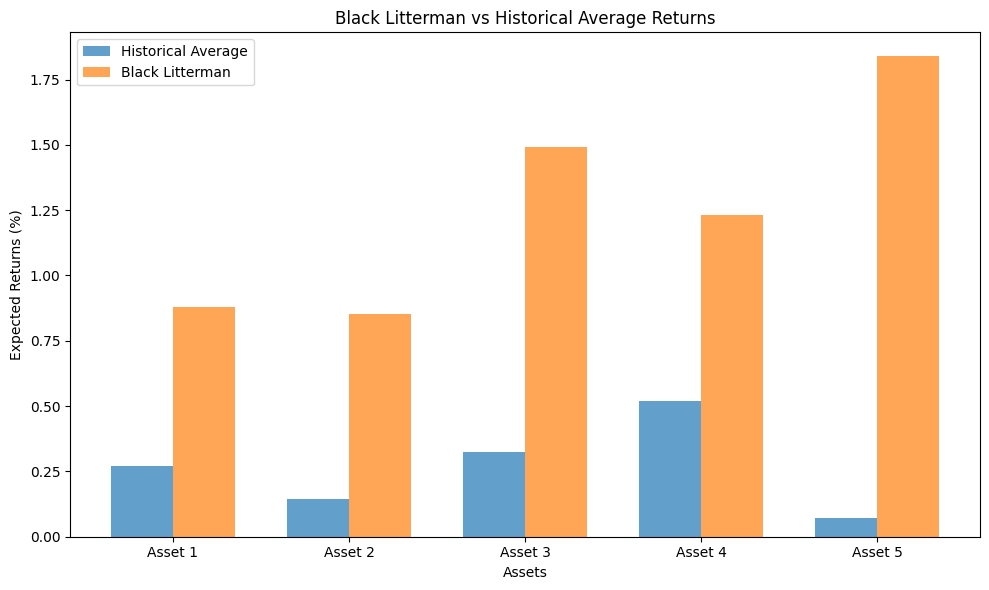

In [21]:
historical_avg = returns.mean().to_numpy() * 100  
black_litterman = expected_returns * 100  
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(historical_avg))
plt.bar(index, historical_avg, bar_width, label='Historical Average', alpha=0.7)
plt.bar(index + bar_width, black_litterman, bar_width, label='Black Litterman', alpha=0.7)
plt.xlabel('Assets')
plt.ylabel('Expected Returns (%)')
plt.title('Black Litterman vs Historical Average Returns')
plt.xticks(index + bar_width / 2, [f'Asset {i+1}' for i in range(len(historical_avg))])
plt.legend()
plt.tight_layout()
plt.show()

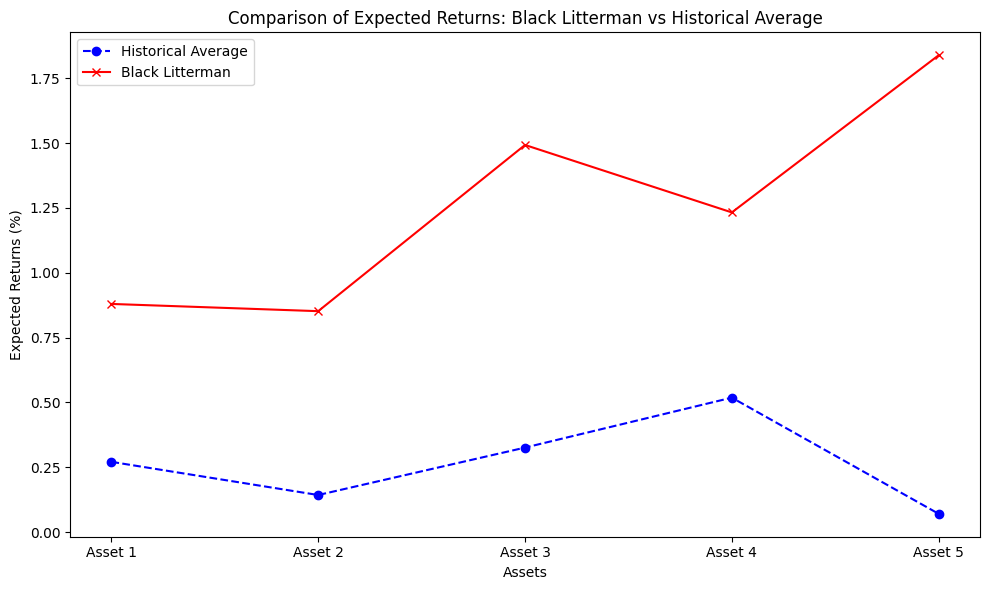

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(historical_avg, marker='o', label='Historical Average', linestyle='--', color='b')
plt.plot(black_litterman, marker='x', label='Black Litterman', linestyle='-', color='r')
plt.xlabel('Assets')
plt.ylabel('Expected Returns (%)')
plt.title('Comparison of Expected Returns: Black Litterman vs Historical Average')
plt.xticks(np.arange(len(historical_avg)), [f'Asset {i+1}' for i in range(len(historical_avg))])
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# Function to compute Black-Litterman expected returns based on tau (input parameter)
def compute_black_litterman_returns(tau):
    # Placeholder for Black-Litterman formula, adjust as per your model
    adjusted_returns = expected_returns * tau  # Using tau to scale the returns
    return adjusted_returns

# Interactive function to update the plot based on tau value
def update_plot(tau):
    adjusted_returns = compute_black_litterman_returns(tau)
    
    # Clear previous plots
    plt.clf()
    
    # Create the updated bar plot
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(historical_avg))

    plt.bar(index, historical_avg, bar_width, label='Historical Average', alpha=0.7)
    plt.bar(index + bar_width, adjusted_returns, bar_width, label=f'Black Litterman (tau={tau:.2f})', alpha=0.7)

    plt.xlabel('Assets')
    plt.ylabel('Expected Returns (%)')
    plt.title('Interactive Black-Litterman Expected Returns')
    plt.xticks(index + bar_width / 2, [f'Asset {i+1}' for i in range(len(historical_avg))])
    plt.legend()

    plt.tight_layout()
    plt.show()

# Slider widget to adjust tau
tau_slider = widgets.FloatSlider(value=0.05, min=0.01, max=1.0, step=0.01, description='Tau:')
widgets.interactive(update_plot, tau=tau_slider)

# Display the interactive slider and plot
display(tau_slider)
